# Importar liberias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# train test split and cross validation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import joblib
# Ajuste de parametros
from sklearn.model_selection import GridSearchCV

from arch import arch_model
import itertools
import warnings

sns.set()
warnings.filterwarnings("ignore")

# Carga de datos


In [ ]:
columns=['npedido', 'nit', 'nombrecliente', 'ciudad', 'codref', 'productoean',
       'descripcion', 'presentacion', 'cantidad', 'precio unitario',
       'subtotal', 'periodo', 'linea', 'fechapedido', 'canal', 'zona',
       'cantidadfactura', 'preciofactura', 'subtotalfacturado']

In [ ]:
# Carga el archivo csv
# df_2021 = pd.read_csv('2021.csv',on_bad_lines='skip',sep=';',names=columns)
df_2022 = pd.read_csv('/content/drive/MyDrive/Proyecto Integrador 2023-2/Datos/2022.csv',on_bad_lines='skip',sep=';',names=columns)
# df_2023 = pd.read_csv('2023.csv',on_bad_lines='skip',sep=';',names=columns)


In [ ]:
# Filtrar por la categoría Acetaminofen
categoria_deseada = 'Acetaminofen 150 mg/ 5mL Jarabe'
# df_2021_ = df_2021[df_2021['Descripcion'] == categoria_deseada]
df_2022_ = df_2022[df_2022['descripcion'] == categoria_deseada]
# df_2023_ = df_2023[df_2023['Descripcion'] == categoria_deseada]


In [ ]:
# Concatena los DataFrames en uno solo
# df = pd.concat([df_2021_, df_2022_, df_2023_], axis=0)
df = pd.concat([df_2022_], axis=0)
# Guarda el DataFrame resultante en un nuevo archivo CSV
df.to_csv('Datos2021-2023.csv')

print(f'El tamaño del dataset es: {df.shape}')

El tamaño del dataset es: (156946, 19)


In [ ]:
df =  df.drop(columns = ['npedido', 'nit',  'codref',
       'subtotal', 'periodo', 'subtotalfacturado','descripcion','linea','zona'])

In [ ]:
# # Lee tus datos (asegúrate de tener una columna de fecha)
df['fechapedido'] = pd.to_datetime(df['fechapedido'])
# df_st.set_index('FechaPedido', inplace=True)
# # # Organiza el DataFrame por la columna de fecha
df = df.sort_values(by='fechapedido')

In [ ]:
# df_sem = df.groupby(pd.Grouper(key='FechaPedido', freq='d')).sum()
# df_sem = df_sem.reset_index()
# # Imprimir el DataFrame agrupado por semana
# print(df_sem)


#  Pipeline de procesamiento

In [ ]:
def agrupar_categorias(df, columna, umbral):
    # Calcula la frecuencia de cada valor en la columna
    frecuencias = df[columna].value_counts()

    # Encuentra los valores que tienen una frecuencia menor al umbral
    categorias_a_agrupar = frecuencias[frecuencias < umbral].index.tolist()

    # Reemplaza las categorías con una frecuencia menor al umbral con 'Other'
    df[columna] = df[columna].apply(lambda x: 'Other' if x in categorias_a_agrupar else x)

    return df

In [ ]:
# Aplica la función para agrupar categorías con una frecuencia menor a 3
df_agrupado= agrupar_categorias(df, 'presentacion', 800)
df_agrupado = agrupar_categorias(df_agrupado, 'canal', 3000)
# Imprime el DataFrame resultante
print(df_agrupado)

                                             nombrecliente          ciudad  \
1733279               DISTRIBUIDORA FARMACEUTICA ROMA S.A.       MEDELLIN    
1923271  PERFUMERIA COSMETICOS Y FARMACEUTICOS LTDA - P...         BOGOTA    
1923270  PERFUMERIA COSMETICOS Y FARMACEUTICOS LTDA - P...         BOGOTA    
1923269  PERFUMERIA COSMETICOS Y FARMACEUTICOS LTDA - P...         BOGOTA    
1923268  PERFUMERIA COSMETICOS Y FARMACEUTICOS LTDA - P...         BOGOTA    
...                                                    ...             ...   
1968398  DISTRIBUIDORA COLOMBIANA DE MEDICAMENTOS S.A.S...  VILLAVICENCIO    
1968411  DISTRIBUIDORA COLOMBIANA DE MEDICAMENTOS S.A.S...  VILLAVICENCIO    
1635116  DISTRIBUIDORA COLOMBIANA DE MEDICAMENTOS S.A.S...          TUNJA    
1023209            DROGUERIAS Y FARMACIAS CRUZ VERDE S.A.S         BOGOTA    
3438857            DROGUERIAS Y FARMACIAS CRUZ VERDE S.A.S         BOGOTA    

           productoean  presentacion  cantidad  precio unitario

In [ ]:
cat_cols = df_agrupado.select_dtypes(include=object).columns
#Definimos nuestro Pipeline de pre-procesamiento
categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='passthrough'
)
# Fit and transform the DataFrame using the ColumnTransformer
transformed_df= preprocessor.fit_transform(df_agrupado)

# Get the transformed feature names
transformed_columns = preprocessor.get_feature_names_out()

# # Remove 'cat__' and 'remainder__' prefixes from the column names
cleaned_columns = [col.replace('cat__', '').replace('remainder__', '') for col in transformed_columns]


# # Create a new DataFrame with the transformed data and column names
encoded_df = pd.DataFrame(transformed_df, columns=cleaned_columns)
print(encoded_df)


       nombrecliente ciudad productoean presentacion canal cantidad  \
0               54.0   25.0         3.0          0.0   0.0     6000   
1              128.0    5.0         3.0          0.0   0.0     3600   
2              128.0    5.0         3.0          0.0   0.0     3600   
3              128.0    5.0         3.0          0.0   0.0     3600   
4              128.0    5.0         3.0          0.0   0.0     3600   
...              ...    ...         ...          ...   ...      ...   
156941          50.0   39.0         0.0          1.0   1.0     4032   
156942          50.0   39.0         0.0          1.0   1.0     4032   
156943          50.0   36.0         0.0          1.0   1.0     1764   
156944          69.0    5.0         0.0          1.0   1.0     1008   
156945          69.0    5.0         0.0          1.0   1.0      504   

       precio unitario fechapedido cantidadfactura preciofactura  
0                 1989  2022-01-03            16.0        3200.0  
1            

In [ ]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156946 entries, 0 to 156945
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   nombrecliente    156946 non-null  object        
 1   ciudad           156946 non-null  object        
 2   productoean      156946 non-null  object        
 3   presentacion     156946 non-null  object        
 4   canal            156946 non-null  object        
 5   cantidad         156946 non-null  object        
 6   precio unitario  156946 non-null  object        
 7   fechapedido      156946 non-null  datetime64[ns]
 8   cantidadfactura  156720 non-null  object        
 9   preciofactura    156720 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 12.0+ MB


In [ ]:

# # Convertir todas las columnas de object a float
# encoded_df = encoded_df.apply(pd.to_numeric, errors='coerce')
# encoded_df.dtypes

In [ ]:
# # Lee tus datos (asegúrate de tener una columna de fecha)
encoded_df['fechapedido'] = pd.to_datetime(encoded_df['fechapedido'])
# df_st.set_index('FechaPedido', inplace=True)
# # # Organiza el DataFrame por la columna de fecha
encoded_df = encoded_df.sort_values(by='fechapedido')
encoded_df.dtypes

nombrecliente              object
ciudad                     object
productoean                object
presentacion               object
canal                      object
cantidad                   object
precio unitario            object
fechapedido        datetime64[ns]
cantidadfactura            object
preciofactura              object
dtype: object

In [ ]:
# # Convertir las columnas de object a float utilizando astype(float)
# encoded_df['Precio Unitario'] = encoded_df['Precio Unitario'].astype(float, errors='ignore')
# encoded_df['Cantidad'] = encoded_df['Cantidad'].astype(float, errors='ignore')

In [ ]:
# num_cols = encoded_df.select_dtypes(include=np.number).columns

In [ ]:
# scaler = StandardScaler()
# df__=encoded_df[num_cols]
# df_scaled_numericas = scaler.fit_transform(df__)

In [ ]:
# encoded_df[num_cols]=df_scaled_numericas

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_df.drop(columns=['cantidad','fechapedido','cantidadfactura', 'preciofactura']),
    encoded_df['cantidad'], test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,y_train, test_size=0.2,
    random_state=42
)

In [ ]:
X_test

,nombrecliente,ciudad,productoean,presentacion,canal,precio unitario
105690,29.0,2.0,3.0,0.0,0.0,2285
51434,115.0,34.0,2.0,2.0,0.0,1650
123230,44.0,2.0,1.0,1.0,0.0,1650
11289,98.0,12.0,1.0,1.0,0.0,1123
49371,108.0,29.0,1.0,1.0,0.0,1250
...,...,...,...,...,...,...
14915,123.0,7.0,3.0,0.0,0.0,1989
22472,29.0,40.0,3.0,0.0,0.0,1989
63084,70.0,6.0,1.0,1.0,0.0,1250
86520,43.0,2.0,3.0,0.0,0.0,2400


In [ ]:
X=encoded_df.drop(columns=['cantidad','fechapedido','cantidadfactura', 'preciofactura'])
y=encoded_df['cantidad']

In [ ]:
X

,nombrecliente,ciudad,productoean,presentacion,canal,precio unitario
0,54.0,25.0,3.0,0.0,0.0,1989
863,54.0,7.0,1.0,1.0,0.0,1123
862,54.0,7.0,1.0,1.0,0.0,1123
861,54.0,7.0,1.0,1.0,0.0,1123
860,54.0,7.0,1.0,1.0,0.0,1123
...,...,...,...,...,...,...
156916,89.0,25.0,3.0,0.0,0.0,2600
156917,89.0,25.0,3.0,0.0,0.0,2600
156906,50.0,36.0,0.0,1.0,1.0,1250
156944,69.0,5.0,0.0,1.0,1.0,1250


In [ ]:

# feature_names = X.columns#[f"feature {i}" for i in range(X.shape[1])]
# forest = RandomForestClassifier(random_state=0)
# forest.fit(X_train, y_train)
# importances = forest.feature_importances_
# forest_importances = pd.Series(importances, index=feature_names)
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# fig, ax = plt.subplots(1,2)
# # ax[0].plot.bar(forest_importances, yerr=std )
# forest_importances.sort_values(ascending=True).plot.bar(yerr=std, ax=ax[0])
# ax[0].set_title("Feature importances using MDI Random forest")
# ax[0].set_ylabel("Mean decrease in impurity")
# forest = GradientBoostingClassifier(n_estimators=100, random_state=0 ).fit(X_train, y_train)
# importances = forest.feature_importances_
# forest_importances = pd.Series(importances, index=feature_names)

# # ax[0].plot.bar(forest_importances, yerr=std )
# forest_importances.sort_values(ascending=True).plot.bar( ax=ax[1])
# ax[1].set_title("Feature importances using MDI Gradient boosting")
# ax[1].set_ylabel("Mean decrease in impurity")

# fig.set_figheight(5)
# fig.set_figwidth(12)
# fig.tight_layout()

In [ ]:
# forest_importances.sort_values(ascending=False).iloc[0:6].index

In [ ]:
# datos= ['NOMBRECLIENTE', 'Precio Unitario', 'CIUDAD', 'zona', 'ProductoEAN',
#        'presentación']

# Modelos



# Series de tiempo

In [ ]:
# Selecciona solo las dos columnas que deseas copiar
cs = ['fechapedido', 'cantidad']
df_st = df[cs].copy()

In [ ]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, zero = False, lags = 40, ax = axes[0])
    sgt.plot_pacf(series, zero = False, lags = 40, ax = axes[1])

    plt.show()

In [ ]:
# # Lee tus datos (asegúrate de tener una columna de fecha)
df_st['fechapedido'] = pd.to_datetime(df_st['fechapedido'])
# df_st.set_index('FechaPedido', inplace=True)
# # # Organiza el DataFrame por la columna de fecha
df_st = df_st.sort_values(by='fechapedido')

In [ ]:
df_st.describe()

,cantidad
count,156946.000000
mean,8582.058976
std,12759.501077
min,2.000000
25%,1500.000000
50%,4800.000000
75%,10560.000000
max,300000.000000


In [ ]:
df_st.dtypes

fechapedido    datetime64[ns]
cantidad                int64
dtype: object

In [ ]:
df_day = pd.DataFrame()
df_day['cantidad'] = df_st.groupby(pd.Grouper(key='fechapedido', freq='D'))['cantidad'].sum()
df_day.index = pd.DatetimeIndex(df_day.index.values, freq=df_day.index.inferred_freq)
df_day.describe()

,cantidad
count,3.620000e+02
mean,3.720773e+06
std,5.519114e+06
min,0.000000e+00
25%,5.280000e+02
50%,1.422583e+06
75%,5.115694e+06
max,2.992614e+07


In [ ]:
df_day

,cantidad
2022-01-03,7268921
2022-01-04,2806116
2022-01-05,1685486
2022-01-06,2077210
2022-01-07,1763576
...,...
2022-12-26,450700
2022-12-27,36792
2022-12-28,310296
2022-12-29,0


<Axes: >

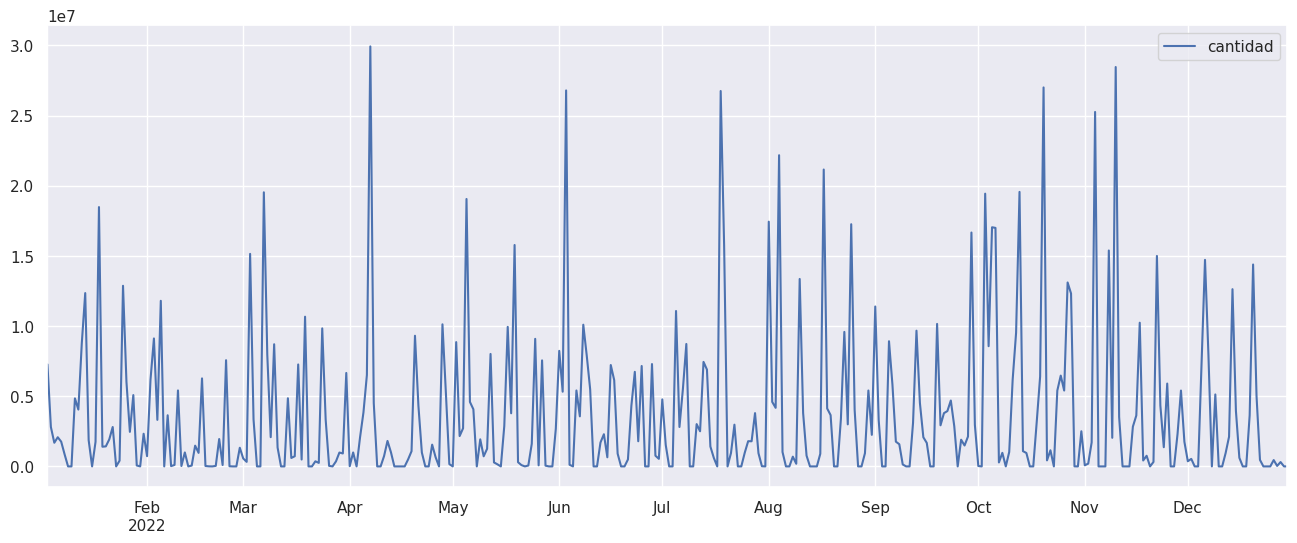

In [ ]:
### PLOT DATOS DIARIOS ###

df_day.plot(figsize=(16,6))

In [ ]:
# Encuentra la fecha mínima y máxima
fecha_minima = df_day.index.min()
fecha_maxima = df_day.index.max()

print(f"Fecha mínima: {fecha_minima}")
print(f"Fecha máxima: {fecha_maxima}")

Fecha mínima: 2022-01-03 00:00:00
Fecha máxima: 2022-12-30 00:00:00


In [ ]:
# Agrupar los datos por dia y calcular la suma de 'Cantidad' en cada dia
df_day = df_day.resample('D').sum()
df_day

,cantidad
2022-01-03,7268921
2022-01-04,2806116
2022-01-05,1685486
2022-01-06,2077210
2022-01-07,1763576
...,...
2022-12-26,450700
2022-12-27,36792
2022-12-28,310296
2022-12-29,0


In [ ]:
frecuencia = df_day.index.freq
print(f"Frecuencia de la serie temporal: {frecuencia}")

Frecuencia de la serie temporal: <Day>


In [ ]:
# Calcula el índice para dividir los datos
indice_division = int(0.8 * len(df_day))

# Divide los datos en conjuntos de entrenamiento y validación
train_df = df_day.iloc[:indice_division]
test_df = df_day.iloc[indice_division:]

In [ ]:
print(test_df.index.min())
print(test_df.index.max())

2022-10-19 00:00:00
2022-12-30 00:00:00


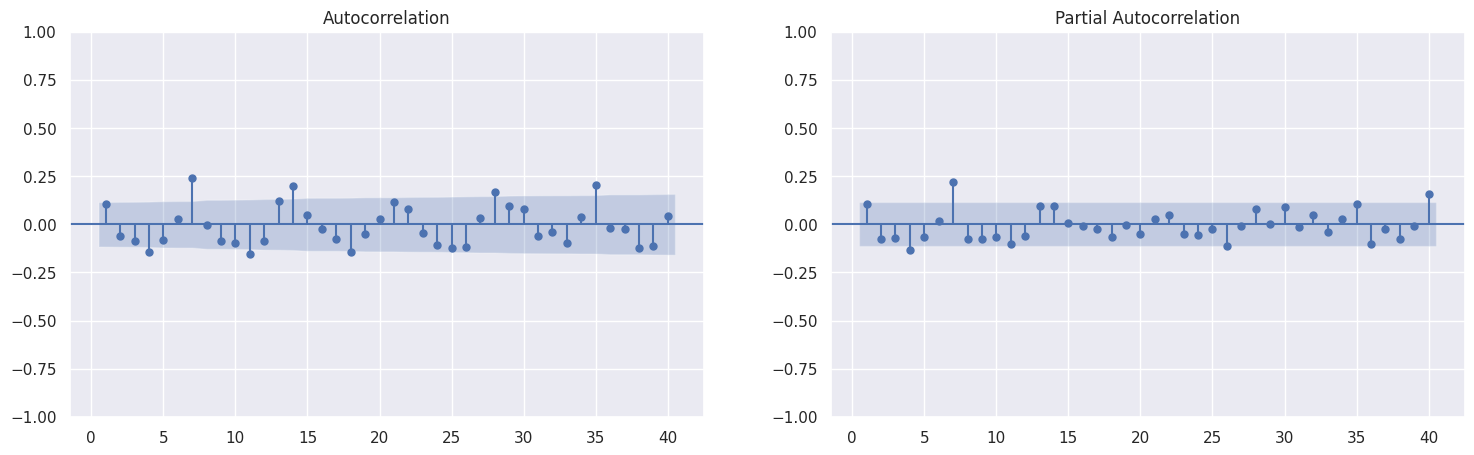

(-4.274985188347453,
 0.0004906680502614568,
 13,
 275,
 {'1%': -3.454355055831705,
  '5%': -2.8721080938842976,
  '10%': -2.572401325619835},
 9179.460595054075)

In [ ]:
# Stationarity
plot_acf_pacf(train_df["cantidad"])
adfuller(train_df["cantidad"])

el p-valor es menor que 0.05, lo que sugiere que puedes rechazar la hipótesis nula y concluir que la serie temporal es estacionaria

### SARIMAX

In [ ]:
# Definir rangos para p, d, q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Crear combinaciones de p, d, q
combinaciones = list(itertools.product(p_values, d_values, q_values))

# Inicializar variables
mejor_pdq = None
mejor_mse = float('inf')

# Probar todas las combinaciones
for pdq in combinaciones:
    try:
        modelo_arima = SARIMAX(train_df["cantidad"], order=pdq)
        resultado_arima = modelo_arima.fit()

        # Realizar predicciones en un conjunto de prueba (deberías dividir tus datos)
        predicciones = resultado_arima.predict(start=test_df.index[0], end=test_df.index[-1])

        # Calcular el MSE
        mse = mean_squared_error(test_df["cantidad"], predicciones)

        # Actualizar el mejor modelo si es necesario
        if mse < mejor_mse:
            mejor_mse = mse
            mejor_pdq = pdq

    except:
        continue

print(f"Mejor combinación de p, d, q: {mejor_pdq}")


Mejor combinación de p, d, q: (1, 1, 2)


In [ ]:
modelo_sarima_ = sm.tsa.SARIMAX(train_df['cantidad'], order=(1, 1, 2), seasonal_order=(1, 1, 1, 12))
resultado = modelo_sarima_.fit()

In [ ]:
predictions= resultado.predict(start=test_df.index[0], end=test_df.index[-1])


In [ ]:
modelo_sarima_v2 = SARIMAX(train_df['cantidad'].dropna(), order=(1, 1, 2))
model_fit = modelo_sarima_v2.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               cantidad   No. Observations:                  289
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -4867.473
Date:                Tue, 21 Nov 2023   AIC                           9742.946
Time:                        13:01:27   BIC                           9757.598
Sample:                    01-03-2022   HQIC                          9748.818
                         - 10-18-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7760      0.188     -4.130      0.000      -1.144      -0.408
ma.L1         -0.1287      0.148     -0.870      0.384      -0.419       0.161
ma.L2         -0.8555      0.137     -6.231      0.000      -1.125      -0.586
sigma2      3.181e+13   1.61e-14   1.98e+27      0.000    3.18e+13    3.18e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               584.21
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             2.21
Prob(H) (two-sided):                  0.04   Kurtosis:                         8.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.31e+43. Standard errors may be unstable.
"""

In [ ]:
train_df

,cantidad
2022-01-03,7268921
2022-01-04,2806116
2022-01-05,1685486
2022-01-06,2077210
2022-01-07,1763576
...,...
2022-10-14,1087248
2022-10-15,955224
2022-10-16,0
2022-10-17,0


In [ ]:
# Medicion de la predicción
mse_validacion = mean_squared_error(test_df['cantidad'], predictions)
rmse = np.sqrt(mse_validacion)
print(f'RMSE en datos de validación: {rmse}')

RMSE en datos de validación: 6544503.293453917


In [ ]:
# Medicion de la predicción
r2_validacion = r2_score(test_df['cantidad'], predictions)

print(f'R2 en datos de validación: {r2_validacion}')

R2 en datos de validación: -0.051994886266799156


## Modelos de ensamble y no lineales

In [ ]:

# Definir modelos base
random_state = 34
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)
bg_base = BaggingRegressor(random_state=random_state)
et_base = ExtraTreesRegressor(random_state=random_state)
svr_base = SVR()
knn_base = KNeighborsRegressor()
dt_base = DecisionTreeRegressor()

# Definir la malla de parámetros para GridSearchCV
param_grid = {
    'Regressor__n_estimators': [50, 100],
    'Regressor__max_depth': list(range(2, 8)),
    'Regressor__min_samples_leaf': [1, 10, 50]
}
param_grid_bg = {
    'Regressor__n_estimators': [50, 100]
}
param_grid_ = {
    'Regressor__n_neighbors': [3, 5, 7],
    'Regressor__weights': ['uniform', 'distance']
}

param_grid_dt = {
    'Regressor__max_depth': list(range(2, 8)),
    'Regressor__min_samples_leaf': [1, 10, 50]
}
# Definir el rango de parámetros a explorar
param_grid_svr = {
    # 'Regressor__kernel': ['linear', 'rbf', 'poly'],
    'Regressor__C': [0.1, 1, 10],
    # # 'Regressor__gamma': ['scale', 'auto', 0.1, 1],
    # # 'Regressor__epsilon': [0.1, 0.01, 0.001]
}

# Definir pipelines para cada modelo
pipeline_rf = Pipeline(steps=[('Regressor', rf_base)])
pipeline_gb = Pipeline(steps=[('Regressor', gb_base)])
pipeline_bg = Pipeline(steps=[('Regressor', bg_base)])
pipeline_et = Pipeline(steps=[('Regressor', et_base)])
pipeline_svr = Pipeline(steps=[('Regressor', svr_base)])
pipeline_knn = Pipeline(steps=[('Regressor', knn_base)])
pipeline_dt = Pipeline(steps=[('Regressor', dt_base)])

# Definir modelos mediante GridSearchCV
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)
bg = GridSearchCV(pipeline_bg, cv=3, param_grid=param_grid_bg)
et = GridSearchCV(pipeline_et, cv=3, param_grid=param_grid)
svr = GridSearchCV(pipeline_svr, cv=2, param_grid=param_grid_svr)
knn = GridSearchCV(pipeline_knn, cv=3, param_grid=param_grid_)
dt = GridSearchCV(pipeline_dt, cv=3, param_grid=param_grid_dt)


In [ ]:
%%time
# Entrenemos el random forest:
gb.fit(X_train, y_train)

CPU times: user 5min 53s, sys: 396 ms, total: 5min 54s
Wall time: 5min 58s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Regressor',
                                        GradientBoostingRegressor(random_state=34))]),
             param_grid={'Regressor__max_depth': [2, 3, 4, 5, 6, 7],
                         'Regressor__min_samples_leaf': [1, 10, 50],
                         'Regressor__n_estimators': [50, 100]})

In [ ]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)


CPU times: user 4min 14s, sys: 523 ms, total: 4min 14s
Wall time: 4min 22s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Regressor',
                                        RandomForestRegressor(random_state=34))]),
             param_grid={'Regressor__max_depth': [2, 3, 4, 5, 6, 7],
                         'Regressor__min_samples_leaf': [1, 10, 50],
                         'Regressor__n_estimators': [50, 100]})

In [ ]:
%%time
# Entrenemos el Bagging:
bg.fit(X_train, y_train)


CPU times: user 1min 8s, sys: 128 ms, total: 1min 8s
Wall time: 1min 9s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Regressor',
                                        BaggingRegressor(random_state=34))]),
             param_grid={'Regressor__n_estimators': [50, 100]})

In [ ]:
%%time
# Entrenemos el Extra Trees:
et.fit(X_train, y_train)


CPU times: user 2min 36s, sys: 298 ms, total: 2min 36s
Wall time: 2min 37s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Regressor',
                                        ExtraTreesRegressor(random_state=34))]),
             param_grid={'Regressor__max_depth': [2, 3, 4, 5, 6, 7],
                         'Regressor__min_samples_leaf': [1, 10, 50],
                         'Regressor__n_estimators': [50, 100]})

In [ ]:
%%time
# Entrenemos el SVR:
svr_base.fit(X_train, y_train)


CPU times: user 11min 21s, sys: 719 ms, total: 11min 21s
Wall time: 11min 23s


SVR()

In [ ]:
%%time
# Entrenemos el KNeighbors Regressor:
knn.fit(X_train, y_train)


CPU times: user 19.4 s, sys: 57.8 ms, total: 19.4 s
Wall time: 19.6 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Regressor', KNeighborsRegressor())]),
             param_grid={'Regressor__n_neighbors': [3, 5, 7],
                         'Regressor__weights': ['uniform', 'distance']})

In [ ]:
%%time
# Entrenemos el KNeighbors Regressor:
dt.fit(X_train, y_train)

CPU times: user 8.25 s, sys: 21 ms, total: 8.28 s
Wall time: 8.3 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Regressor', DecisionTreeRegressor())]),
             param_grid={'Regressor__max_depth': [2, 3, 4, 5, 6, 7],
                         'Regressor__min_samples_leaf': [1, 10, 50]})

In [ ]:
# Obtengamos los mejores hiperparámetros encontrados para el random forest:
print(f'mejores hiperparámetros encontrados para el random forest: {rf.best_params_}')
print(f'mejores hiperparámetros encontrados para el gradient boosting: {gb.best_params_}')
print(f'mejores hiperparámetros encontrados para el bagging: {bg.best_params_}')
print(f'mejores hiperparámetros encontrados para el extra trees: {et.best_params_}')
# print(f'mejores hiperparámetros encontrados para el SVR: {svr_base.best_params_}')
print(f'mejores hiperparámetros encontrados para el KNeighbors: {knn.best_params_}')
print(f'mejores hiperparámetros encontrados para el Decision Tree: {dt.best_params_}')

mejores hiperparámetros encontrados para el random forest: {'Regressor__max_depth': 7, 'Regressor__min_samples_leaf': 1, 'Regressor__n_estimators': 100}
mejores hiperparámetros encontrados para el gradient boosting: {'Regressor__max_depth': 7, 'Regressor__min_samples_leaf': 1, 'Regressor__n_estimators': 100}
mejores hiperparámetros encontrados para el bagging: {'Regressor__n_estimators': 100}
mejores hiperparámetros encontrados para el extra trees: {'Regressor__max_depth': 7, 'Regressor__min_samples_leaf': 1, 'Regressor__n_estimators': 50}
mejores hiperparámetros encontrados para el KNeighbors: {'Regressor__n_neighbors': 7, 'Regressor__weights': 'distance'}
mejores hiperparámetros encontrados para el Decision Tree: {'Regressor__max_depth': 7, 'Regressor__min_samples_leaf': 1}


### modelos con los parametros de mejor rendimiento

In [ ]:
%%time
rf_best = RandomForestRegressor(random_state=random_state,max_depth= 7, min_samples_leaf= 1, n_estimators= 100).fit(X_train, y_train)



CPU times: user 7.56 s, sys: 26.3 ms, total: 7.59 s
Wall time: 16 s


In [ ]:
%%time
gb_best = GradientBoostingRegressor(random_state=random_state,max_depth= 7, min_samples_leaf= 1, n_estimators= 100).fit(X_train, y_train)

CPU times: user 12.5 s, sys: 45.6 ms, total: 12.6 s
Wall time: 14.8 s


In [ ]:
%%time
bg_best =BaggingRegressor(random_state=random_state,n_estimators= 100).fit(X_train, y_train)

CPU times: user 16.9 s, sys: 40.9 ms, total: 16.9 s
Wall time: 17 s


In [ ]:
%%time
et_best=ExtraTreesRegressor(random_state=random_state,max_depth= 7, min_samples_leaf= 1, n_estimators= 50).fit(X_train, y_train)

CPU times: user 1.73 s, sys: 5.98 ms, total: 1.74 s
Wall time: 1.74 s


In [ ]:
%%time
knn_best=KNeighborsRegressor(n_neighbors= 7, weights= 'distance').fit(X_train, y_train)

CPU times: user 185 ms, sys: 1 ms, total: 186 ms
Wall time: 187 ms


In [ ]:
%%time
dt_best=DecisionTreeRegressor(random_state=random_state,max_depth= 7, min_samples_leaf= 1).fit(X_train, y_train)

CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 147 ms


In [ ]:
%%time
svr_best=SVR().fit(X_train, y_train)

CPU times: user 12min 9s, sys: 729 ms, total: 12min 10s
Wall time: 12min 14s


In [ ]:
# val_pred_svr=svr_best.predict(X_val)
# test_pred_svr=svr_best.predict(X_test)
# mse_test_svr= mean_squared_error(y_test, test_pred_svr)
# r2_test_svr= r2_score(y_test, test_pred_svr)
# # Evaluamos los datos del modelo de los datos de validacion
# mse_val_svr= mean_squared_error(y_val, val_pred_svr)
# r2_val_svr= r2_score(y_val, val_pred_svr)

In [ ]:
# Hacemos la prediccion de los datos de validacion
val_pred_rf=rf_best.predict(X_val)
val_pred_gb=gb_best.predict(X_val)
val_pred_bg=bg_best.predict(X_val)
val_pred_et=et_best.predict(X_val)
val_pred_svr=svr_best.predict(X_val)
val_pred_knn=knn_best.predict(X_val)
val_pred_dt=dt_best.predict(X_val)

In [ ]:
# Hacemos la predicción de los datos de testeo
test_pred_rf=rf_best.predict(X_test)
test_pred_gb=gb_best.predict(X_test)
test_pred_bg=bg_best.predict(X_test)
test_pred_et=et_best.predict(X_test)
test_pred_svr=svr_best.predict(X_test)
test_pred_knn=knn_best.predict(X_test)
test_pred_dt=dt_best.predict(X_test)

In [ ]:
# Evaluamos los datos del modelo de los datos de testeo

# Mean square Error
mse_test_rf= np.sqrt(mean_squared_error(y_test, test_pred_rf))
mse_test_gb= np.sqrt(mean_squared_error(y_test, test_pred_gb))
mse_test_bg= np.sqrt(mean_squared_error(y_test, test_pred_bg))
mse_test_et= np.sqrt(mean_squared_error(y_test, test_pred_et))
mse_test_svr= np.sqrt(mean_squared_error(y_test, test_pred_svr))
mse_test_knn= np.sqrt(mean_squared_error(y_test, test_pred_knn))
mse_test_dt= np.sqrt(mean_squared_error(y_test, test_pred_dt))
# R2
r2_test_rf= r2_score(y_test, test_pred_rf)
r2_test_gb= r2_score(y_test, test_pred_gb)
r2_test_bg= r2_score(y_test, test_pred_bg)
r2_test_et= r2_score(y_test, test_pred_et)
r2_test_svr= r2_score(y_test, test_pred_svr)
r2_test_knn= r2_score(y_test, test_pred_knn)
r2_test_dt= r2_score(y_test, test_pred_dt)
# MAE
mae_test_rf= mean_absolute_error(y_test, test_pred_rf)
mae_test_gb= mean_absolute_error(y_test, test_pred_gb)
mae_test_bg= mean_absolute_error(y_test, test_pred_bg)
mae_test_et= mean_absolute_error(y_test, test_pred_et)
mae_test_svr= mean_absolute_error(y_test, test_pred_svr)
mae_test_knn= mean_absolute_error(y_test, test_pred_knn)
mae_test_dt= mean_absolute_error(y_test, test_pred_dt)

In [ ]:
# Evaluamos los datos del modelo de los datos de validacion

# Mean square Error
mse_val_rf= np.sqrt(mean_squared_error(y_val, val_pred_rf))
mse_val_gb= np.sqrt(mean_squared_error(y_val, val_pred_gb))
mse_val_bg= np.sqrt(mean_squared_error(y_val, val_pred_bg))
mse_val_et= np.sqrt(mean_squared_error(y_val, val_pred_et))
mse_val_svr= np.sqrt(mean_squared_error(y_val, val_pred_svr))
mse_val_knn= np.sqrt(mean_squared_error(y_val, val_pred_knn))
mse_val_dt= np.sqrt(mean_squared_error(y_val, val_pred_dt))
# R2
r2_val_rf= r2_score(y_val, val_pred_rf)
r2_val_gb= r2_score(y_val, val_pred_gb)
r2_val_bg= r2_score(y_val, val_pred_bg)
r2_val_et= r2_score(y_val, val_pred_et)
r2_val_svr= r2_score(y_val, val_pred_svr)
r2_val_knn= r2_score(y_val, val_pred_knn)
r2_val_dt= r2_score(y_val, val_pred_dt)
# Mean square Error
mae_val_rf= mean_absolute_error(y_val, val_pred_rf)
mae_val_gb= mean_absolute_error(y_val, val_pred_gb)
mae_val_bg= mean_absolute_error(y_val, val_pred_bg)
mae_val_et= mean_absolute_error(y_val, val_pred_et)
mae_val_svr= mean_absolute_error(y_val, val_pred_svr)
mae_val_knn= mean_absolute_error(y_val, val_pred_knn)
mae_val_dt= mean_absolute_error(y_val, val_pred_dt)

In [ ]:
# Supongamos que tienes un DataFrame llamado resultados con las puntuaciones de los modelos
# Algoritmos=['Random Forest','gradient boosting','bagging','extra trees','SVR','KNeighbors','Decision Tree']
resultados = {
    "Algoritmo": ['Random Forest','gradient boosting','bagging','extra trees','SVR','KNeighbors','Decision Tree'],
    "RMSE testeo": [mse_test_rf, mse_test_bg,mse_test_gb,mse_test_et,mse_test_svr,mse_test_knn,mse_test_dt],
    "RMSE validación": [mse_val_rf, mse_val_bg,mse_val_gb,mse_val_et,mse_val_svr,mse_val_knn,mse_val_dt],
    "R2 testeo": [r2_test_rf, r2_test_bg,r2_test_gb,r2_test_et,r2_test_svr,r2_test_knn,r2_test_dt],
    "R2 validación": [r2_val_rf, r2_val_bg,r2_val_gb,r2_val_et,r2_val_svr,r2_val_knn,r2_val_dt],
    "MAE testeo": [mae_test_rf, mae_test_bg,mae_test_gb,mae_test_et,mae_test_svr,mae_test_knn,mae_test_dt],
    "MAE validación": [mae_val_rf, mae_val_bg,mae_val_gb,mae_val_et,mae_val_svr,mae_val_knn,mae_val_dt],
}
resultados= pd.DataFrame(resultados)

# Imprime el DataFrame resultante
# print(resultados)
resultados


,Algoritmo,RMSE testeo,RMSE validación,R2 testeo,R2 validación,MAE testeo,MAE validación
0,Random Forest,9873.309135,10102.641106,0.435485,0.394281,5080.121448,5079.728181
1,gradient boosting,7719.860243,7603.045701,0.654881,0.656935,3284.615081,3239.336889
2,bagging,7777.744193,7691.854788,0.649686,0.648874,3536.508084,3503.207531
3,extra trees,10315.323542,10324.286528,0.383809,0.367412,5560.925081,5532.382528
4,SVR,13734.288000,13534.700144,-0.092351,-0.087172,6792.053007,6654.824382
5,KNeighbors,8686.508091,8899.880700,0.563041,0.529923,3383.525051,3385.117309
6,Decision Tree,10016.605346,10268.160912,0.418980,0.374271,5167.977195,5160.719815


# Modelo seleccionado

In [ ]:
# model = SVR()
# model.fit(X_train,y_train)

In [ ]:
# 1. Entrenar el scaler con tus datos originales
scaler = StandardScaler()
scaler.fit(y_train.to_numpy().reshape(-1, 1))

StandardScaler()

In [ ]:
joblib.dump(scaler, 'escalado.joblib')

['escalado.joblib']

In [ ]:
scaler = joblib.load('escalado.joblib')

In [ ]:
joblib.dump(gb_best, 'modelofinal.joblib')

['modelofinal.joblib']

In [ ]:
modelo1 = joblib.load('modelofinal.joblib')